In [ ]:
# Sources for certain modules used in this notebook

In [52]:
# Keeping all the imports in one place
# -*- coding: utf-8 -*-
import numpy as np
import base64
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
get_ipython().magic(u'matplotlib inline')
from gensim import corpora, models, similarities
import random
from collections import Counter
from __future__ import division
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
#some ipython magic to show the matplotlib plots inline
%matplotlib inline
import gensim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
from tqdm import tqdm
from gensim.models import KeyedVectors
from time import time
print "All the imports worked nicely."

All the imports worked nicely.


In [2]:
# loading pre-trained Deutsche word embeddings from different sources.
# SOURCES:
# Model01 Fb fasttext : pre-trained word vectors, trained on Wikipedia using fastText. These vectors in dimension 300 were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters.
# https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
%time model01 = gensim.models.KeyedVectors.load_word2vec_format("wiki.de.vec", binary=False)

# Model: https://devmount.github.io/GermanWordEmbeddings/
%time model = gensim.models.KeyedVectors.load_word2vec_format("german.model", binary=True)

# Model02 : GER64 embeddings https://github.com/glample/tagger
%time model02 = gensim.models.KeyedVectors.load_word2vec_format("GER64", binary=False)

CPU times: user 10min 3s, sys: 15.6 s, total: 10min 18s
Wall time: 10min 18s
CPU times: user 9.64 s, sys: 1.2 s, total: 10.8 s
Wall time: 10.8 s
CPU times: user 2min 16s, sys: 4.73 s, total: 2min 20s
Wall time: 2min 20s


In [3]:
# ------------------EVALUATING different word embeddings ------------------------------------------------------------------
# Checking the vocabulary size for different embeddings
print "Size of vocabulary in model01 is %d" % len(model01.vocab)
print "Size of vocabulary in model02 is %d" % len(model02.vocab)
print "Size of vocabulary in model is %d" % len(model.vocab)

model_wordList = model.index2word
print type(model_wordList), len(model_wordList)
print "First 50 words in Model vocabulary are: ",  ', '.join(model_wordList[:50])
# model.vocab gives you a dictionary sort of embedding_index_de
# print type(word_vectors.vocab)
# fasttext_wordList = word_vectors.index2word
fasttext_wordList = model01.index2word
print type(fasttext_wordList), len(fasttext_wordList)
print "First 50 words in model01 vocabulary are: ",  ', '.join(fasttext_wordList[:50])

ger64_wordList = model02.index2word
print type(ger64_wordList), len(ger64_wordList)
print "First 50 words in model02 vocabulary are: ",  ', '.join(ger64_wordList[:50])

Size of vocabulary in model01 is 2275233
Size of vocabulary in model02 is 2001952
Size of vocabulary in model is 608130
<type 'list'> 608130
First 50 words in Model vocabulary are:  Die, fuer, wurde, Der, dass, Das, ueber, In, Im, wurden, Er, Sie, Jahr, mehr, zwei, Es, Nach, sowie, ab, Jahren, Jahre, sei, Am, beim, drei, seit, koennen, schon, Euro, Stadt, Mit, ersten, Ein, Auch, gibt, etwa, bereits, jedoch, Zeit, immer, Uhr, Als, Bei, 1, Ende, heute, Fuer, sagte, Von, konnte
<type 'list'> 2275233
First 50 words in model01 vocabulary are:  ., ,, </s>, -, der, ), die, (, und, in, von, ', den, im, das, des, mit, ist, er, zu, für, auf, ein, als, dem, eine, wurde, –, auch, sich, nicht, an, es, nach, war, bei, aus, rd, am, sie, cest, bis, ", ich, einer, zum, werden, sind, oder, wird
<type 'list'> 2001952
First 50 words in model02 vocabulary are:  </s>, ., ,, der, die, und, in, '', den, ``, :, mit, das, von, zu, -, im, auf, sich, ist, für, Die, dem, ein, nicht, -RRB-, -LRB-, des, es, eine, au

In [4]:
# Simple function to visually show and compare different words in the embedding vector space
# Function to visualize 2D vectors using PCA/Tsne
# function draw_words
# ... reduces dimensionality of vectors of given words either with PCA or with t-SNE and draws the words into a diagram
# @param word2vec model     to visualize vectors from
# @param list     words     list of word strings to visualize
# @param bool     pca       use PCA (True) or t-SNE (False) to reduce dimensionality 
# @param bool     alternate use different color and label align for every second word
# @param bool     arrows    use arrows to connect related words (items that are next to each other in list)
# @param float    x1        x axis range (from)
# @param float    x2        x axis range (to)
# @param float    y1        y axis range (from)
# @param float    y2        y axis range (to)
# @param string   title     for diagram
def draw_words(model, words, pca=False, alternate=True, arrows=True, x1=3, x2=3, y1=3, y2=3, title=''):
    # get vectors for given words from model
    try:
        vectors = [model[word] for word in words]
    except KeyError, e:
        print "raised key error now looking for lower case word in the vocabulary"
        vectors = [model[word.lower()] for word in words]
    if pca:
        pca = PCA(n_components=2, whiten=True)
        vectors2d = pca.fit(vectors).transform(vectors)
    else:
        tsne = TSNE(n_components=2, random_state=0)
        vectors2d = tsne.fit_transform(vectors)

    # draw image
    plt.figure(figsize=(6,6))
    if pca:
        plt.axis([x1, x2, y1, y2])

    first = True # color alternation to divide given groups
    for point, word in zip(vectors2d , words):
        # plot points
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        # plot word annotations
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "x-large"
        )
        first = not first if alternate else first
    # draw arrows
    if arrows:
        for i in xrange(0, len(words)-1, 2):
            a = vectors2d[i][0] + 0.04
            b = vectors2d[i][1]
            c = vectors2d[i+1][0] - 0.04
            d = vectors2d[i+1][1]
            plt.arrow(a, b, c-a, d-b,
                shape='full',
                lw=0.1,
                edgecolor='#bbbbbb',
                facecolor='#bbbbbb',
                length_includes_head=True,
                head_width=0.08,
                width=0.01
            )
    # draw diagram title
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

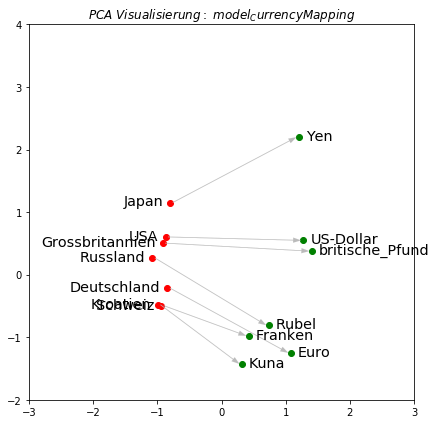

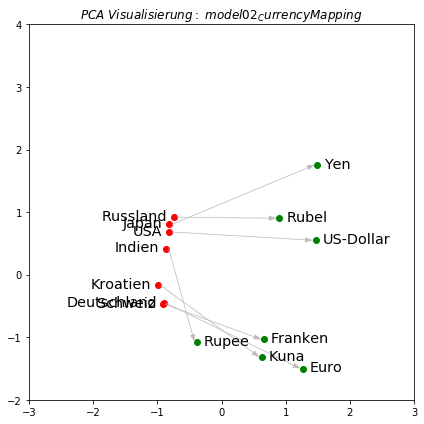

raised key error now looking for lower case word in the vocabulary


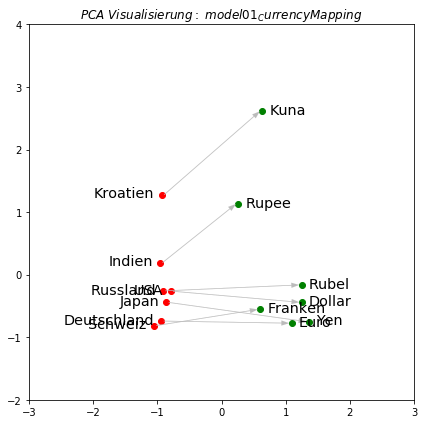

raised key error now looking for lower case word in the vocabulary


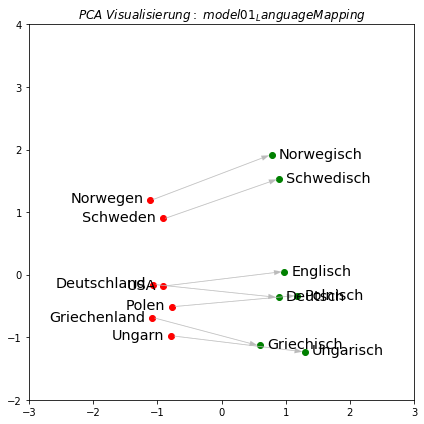

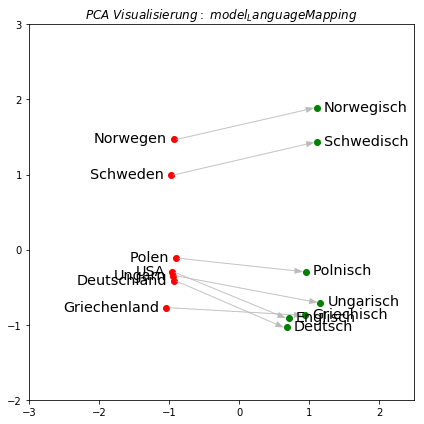

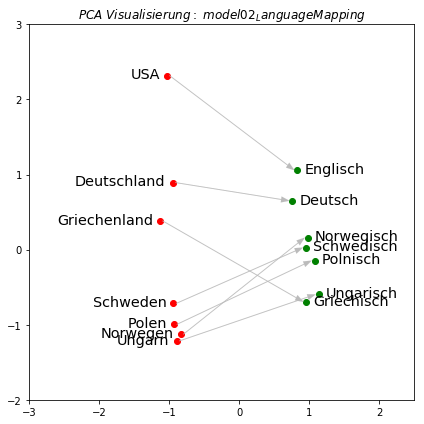

raised key error now looking for lower case word in the vocabulary


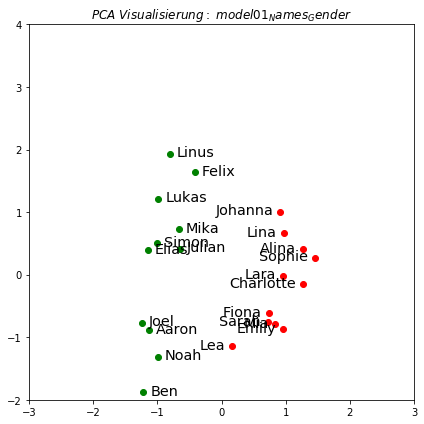

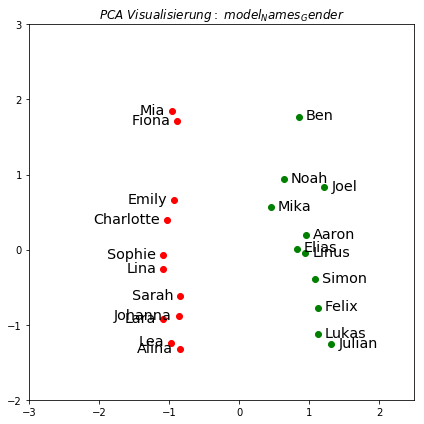

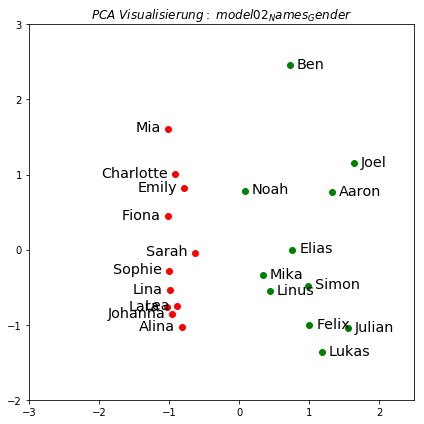

In [5]:
# plot currencies
words = ["Schweiz","Franken","Deutschland","Euro","Grossbritannien","britische_Pfund","Japan","Yen","Russland","Rubel","USA","US-Dollar","Kroatien","Kuna"]
draw_words(model, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model_CurrencyMapping$')

words = ["Schweiz","Franken","Deutschland","Euro","Japan","Yen","Russland","Rubel","USA","US-Dollar","Kroatien","Kuna","Indien", "Rupee"]
draw_words(model02, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model02_CurrencyMapping$')

words = ["Schweiz","Franken","Deutschland","Euro","Japan","Yen","Russland","Rubel","USA","Dollar","Kroatien","Kuna","Indien", "Rupee"]
draw_words(model01, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model01_CurrencyMapping$')

words = ["Deutschland","Deutsch","USA","Englisch","Griechenland","Griechisch","Norwegen","Norwegisch","Schweden","Schwedisch","Polen","Polnisch","Ungarn","Ungarisch"]

draw_words(model01, words, True, True, True, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model01_LanguageMapping$')
draw_words(model, words, True, True, True, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model_LanguageMapping$')
draw_words(model02, words, True, True, True, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model02_LanguageMapping$')

# showing the underlying understanding of word embedding for different gender names   
words = ["Alina","Aaron","Charlotte","Ben","Emily","Elias","Fiona","Felix","Johanna","Joel","Lara","Julian","Lea","Linus","Lina","Lukas","Mia","Mika","Sarah","Noah","Sophie","Simon"]
draw_words(model01, words, True, True, False, -3, 3, -2, 4, r'$PCA\ Visualisierung:\ model01_Names_Gender$')
draw_words(model, words, True, True, False, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model_Names_Gender$')
draw_words(model02, words, True, True, False, -3, 2.5, -2, 3, r'$PCA\ Visualisierung:\ model02_Names_Gender$')

print

In [7]:
# some more examples to show and compare the word embeddings quality and data
print "Results for vector arithematic = Vector[frau] + Vector[koenig] - Vector[mann]"
print "\n model01 resuls \n %s" % model01.most_similar_cosmul(positive=['frau', 'koenig'], negative=['mann'])
# Note: how model02 does not gives the expected results, but still captures other generalized concepts
print "\n model02 resuls \n %s" % model02.most_similar_cosmul(positive=['frau', 'Koenig'], negative=['mann'])
print "\n model resuls \n %s" % model.most_similar_cosmul(positive=['frau', 'Koenig'], negative=['mann'])

print 
# Another example 
print "Results for vector arithematic = Vector[Obama] + Vector[Russland] - Vector[USA]"
print "\n model resuls \n %s" % model.most_similar_cosmul(positive=['Obama', 'Russland'], negative=['USA'])
print "\n model01 resuls \n %s" % model01.most_similar_cosmul(positive=['obama', 'russland'], negative=['usa'])
print "\n model02 resuls \n %s" % model02.most_similar_cosmul(positive=['Obama', 'Russland'], negative=['USA'])

Results for vector arithematic = Vector[frau] + Vector[koenig] - Vector[mann]

 model01 resuls 
 [(u'koenige', 0.9254183769226074), (u'koenigin', 0.9117096066474915), (u'koenigi', 0.8989173173904419), (u'bkoenig', 0.8936635851860046), (u'erlkoenig', 0.8904488682746887), (u'koenigs', 0.8678578734397888), (u'koeniger', 0.8672288060188293), (u'koenigl', 0.8639868497848511), (u'koenigsfeld', 0.8413063287734985), (u'heussner', 0.8398494720458984)]

 model02 resuls 
 [(u'Cewe', 0.9357702732086182), (u'Thonet', 0.9357085227966309), (u'Villeroy', 0.9339916110038757), (u'Krobath', 0.9337064623832703), (u'Bosch', 0.9327762722969055), (u'Dethleffs', 0.9324429631233215), (u'Schoeller', 0.9311891794204712), (u'Schelhammer', 0.9305253624916077), (u'Casualwear', 0.9298563003540039), (u'Wella', 0.929678738117218)]

 model resuls 
 [(u'Prinzen', 0.9462631344795227), (u'Prinzessin', 0.9387489557266235), (u'Koenigin', 0.9133153557777405), (u'Prinz', 0.8993944525718689), (u'Koenigin_Niederlande', 0.895025

In [32]:
print "Results for vector arithematic = Vector[Kerze] + Vector[Feuerzeug]"
print "\n model resuls \n %s" % model.most_similar_cosmul(positive=['Kerze', 'Feuerzeug'])
print "\n model01 resuls \n %s" % model01.most_similar_cosmul(positive=['kerze', 'feuerzeug'])
print "\n model02 resuls \n %s" % model02.most_similar_cosmul(positive=['Kerze', 'Feuerzeug'])

Results for vector arithematic = Vector[Kerze] + Vector[Feuerzeug]

 model resuls 
 [(u'brennende_Kerze', 0.7145117521286011), (u'Herdplatte', 0.710566520690918), (u'brennende_Zigarette', 0.6972489356994629), (u'Teelicht', 0.6950814127922058), (u'Grablicht', 0.687491774559021), (u'eingeschalteten_Herd', 0.6849476099014282), (u'Zigarettenkippe', 0.6791795492172241), (u'Benzinkanister', 0.6780713796615601), (u'Fussmatte', 0.6776428818702698), (u'achtlos_weggeworfene', 0.6759508848190308)]

 model01 resuls 
 [(u'benzinfeuerzeug', 0.742671012878418), (u'feuerzeugflamme', 0.7228692770004272), (u'feuerzeugs', 0.7227802872657776), (u'feuerzeuges', 0.7193080186843872), (u'gasfeuerzeug', 0.709706723690033), (u'tischfeuerzeug', 0.7011693120002747), (u'kerzen', 0.6958333849906921), (u'feuerzeuggas', 0.6925532817840576), (u'feuerzeugen', 0.687744140625), (u'benzinfeuerzeuge', 0.6857927441596985)]

 model02 resuls 
 [(u'Wunderkerze', 0.9350067973136902), (u'Teelicht', 0.933605968952179), (u'Streich

In [6]:
# Setting up word embeddings to be visualized in Tensor Board - 
# load model
# create a list of vectors
embedding = np.empty((len(model02.vocab), 64), dtype=np.float32)
for i, word in enumerate(model02.vocab):
    embedding[i] = model02[word]

# setup a TensorFlow session
tf.reset_default_graph()
sess = tf.InteractiveSession()
X = tf.Variable([0.0], name='embedding')
place = tf.placeholder(tf.float32, shape=embedding.shape)
set_x = tf.assign(X, place, validate_shape=False)
sess.run(tf.global_variables_initializer())
sess.run(set_x, feed_dict={place: embedding})

# write labels, creating a meta file -
with open('/home/D072852/log/metadata_de_model02.tsv', 'w') as f:
    for key in model02.vocab.iteritems() :
        f.write(key[0].encode('utf-8') + '\n')

# create a TensorFlow summary writer
summary_writer = tf.summary.FileWriter('/home/D072852/log', sess.graph)
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
embedding_conf.tensor_name = 'embedding:0'
embedding_conf.metadata_path = os.path.join('/home/D072852/log', 'metadata_de_model02.tsv')
projector.visualize_embeddings(summary_writer, config)

# save the model
saver = tf.train.Saver()
saver.save(sess, os.path.join('/home/D072852/log', "model_de_model02.ckpt"))

'/home/D072852/log/model_de_model02.ckpt'

In [6]:
# --------------------------------------------------------------------------------------------
# ----Beginning with data processing and Thalia Bookstore data specific implementations-------
# ---------------------------------------------------------------------------------------------
# function taking data frame as input preprocess and return another data frame
def dataPreprocess(train) :
    train = train.iloc[:, :-1]
    train.drop(train.columns[0], axis=1, inplace=True)
    print("Number of rows, columns in train dataset : ",train.shape)
    print train.columns
    print train.dtypes
    train.head(2)
    print "Before removing the duplicates\n", train['ADDITIONALTEXT'].describe()
    # dropping the rows with duplicate values in Additional text field -
    train.drop_duplicates(subset='ADDITIONALTEXT', keep="first", inplace=True)
    print "AFTER removing the duplicates\n", train['ADDITIONALTEXT'].describe()
    train.head(2)
    return train

# trying some plotting of data wrt THEMES
def dataVisualise(train) :
    import matplotlib as mpl
    # Just making the plots look better
    mpl.style.use('ggplot')
    mpl.rcParams['figure.figsize'] = (8,6)
    mpl.rcParams['font.size'] = 16
    print "CHECKING for themes now\n", train['THEME'].describe()
    # trying to filter out the long tail and keep only themes with count more than 3
    counts = train['THEME'].value_counts()
    counts1 =  counts[counts >= 2]
    print "DISTRIBUTION of THEMES:"
    print counts1
    plot_data_theme = train[train['THEME'].isin(counts[counts >= 3].index)]
    plot_data_theme['THEME'].value_counts().plot.bar(y='THEME', figsize=(15,10))

    print "CHECKING for keywords now\n", train['SCHLAGWORT'].describe()
    counts = train['SCHLAGWORT'].value_counts()
    counts2 = counts[counts >= 2]
    print "DISTRIBUTION of Schlagworts:"
    print counts2
#     plot_data_schlagwort = train[train['SCHLAGWORT'].isin(counts[counts >= 4].index)]
#     plot_data_schlagwort['SCHLAGWORT'].value_counts().plot.bar(figsize=(25,10))

    # We can see there are only two categories - Subject and Main Subject.
    print "CHECKING for categories now\n", train['CATEGORY'].describe()

# Exploring the data distribution in our train and test set
# trying to filter out the long tail and keep only themes/other attributes with count more 
# than "threshold" value provided
def data_explore(dataFrame, attribute, threshold):
    counts = dataFrame[attribute].value_counts()
    counts1 =  counts[counts >= 1]
    print "DISTRIBUTION of THEMES in data is:"
    print counts1
    plot_data_theme = dataFrame[dataFrame[attribute].isin(counts[counts >= threshold].index)]
    plot_data_theme[attribute].value_counts().plot.bar(y=attribute, figsize=(28,15))

# function to prune the data based on the threshold occurence of number of documents in a specific
# Theme/other attribute
def data_prune(dataFrame, attribute, threshold):
    counts = dataFrame[attribute].value_counts()
    print "DISTRIBUTION of %s in data before Pruning is:" %(attribute)
    counts1 =  counts[counts >= 1]
    print counts1
    print "DISTRIBUTION of THEMES in data after Pruning is:"
    counts2 = counts[counts >= threshold]
    print counts2
    return dataFrame[dataFrame[attribute].isin(counts[counts >= threshold].index)]

CPU times: user 11.7 s, sys: 1.87 s, total: 13.6 s
Wall time: 13.6 s
('Number of rows, columns in train dataset : ', (1000000, 10))
Index([u'MATNR', u'ARTIDENTNO', u'ADDITIONALTEXT', u'RATING', u'RATINGTITEL',
       u'RATINGTEXT', u'RATEDAT', u'SCHLAGWORT', u'CATEGORY', u'THEME'],
      dtype='object')
MATNR             object
ARTIDENTNO         int64
ADDITIONALTEXT    object
RATING             int64
RATINGTITEL       object
RATINGTEXT        object
RATEDAT           object
SCHLAGWORT        object
CATEGORY          object
THEME             object
dtype: object
Before removing the duplicates
count                                               1000000
unique                                                 6777
top       <br>            <p>                <strong>»Ei...
freq                                                  30420
Name: ADDITIONALTEXT, dtype: object
AFTER removing the duplicates
count                                                  6777
unique                            

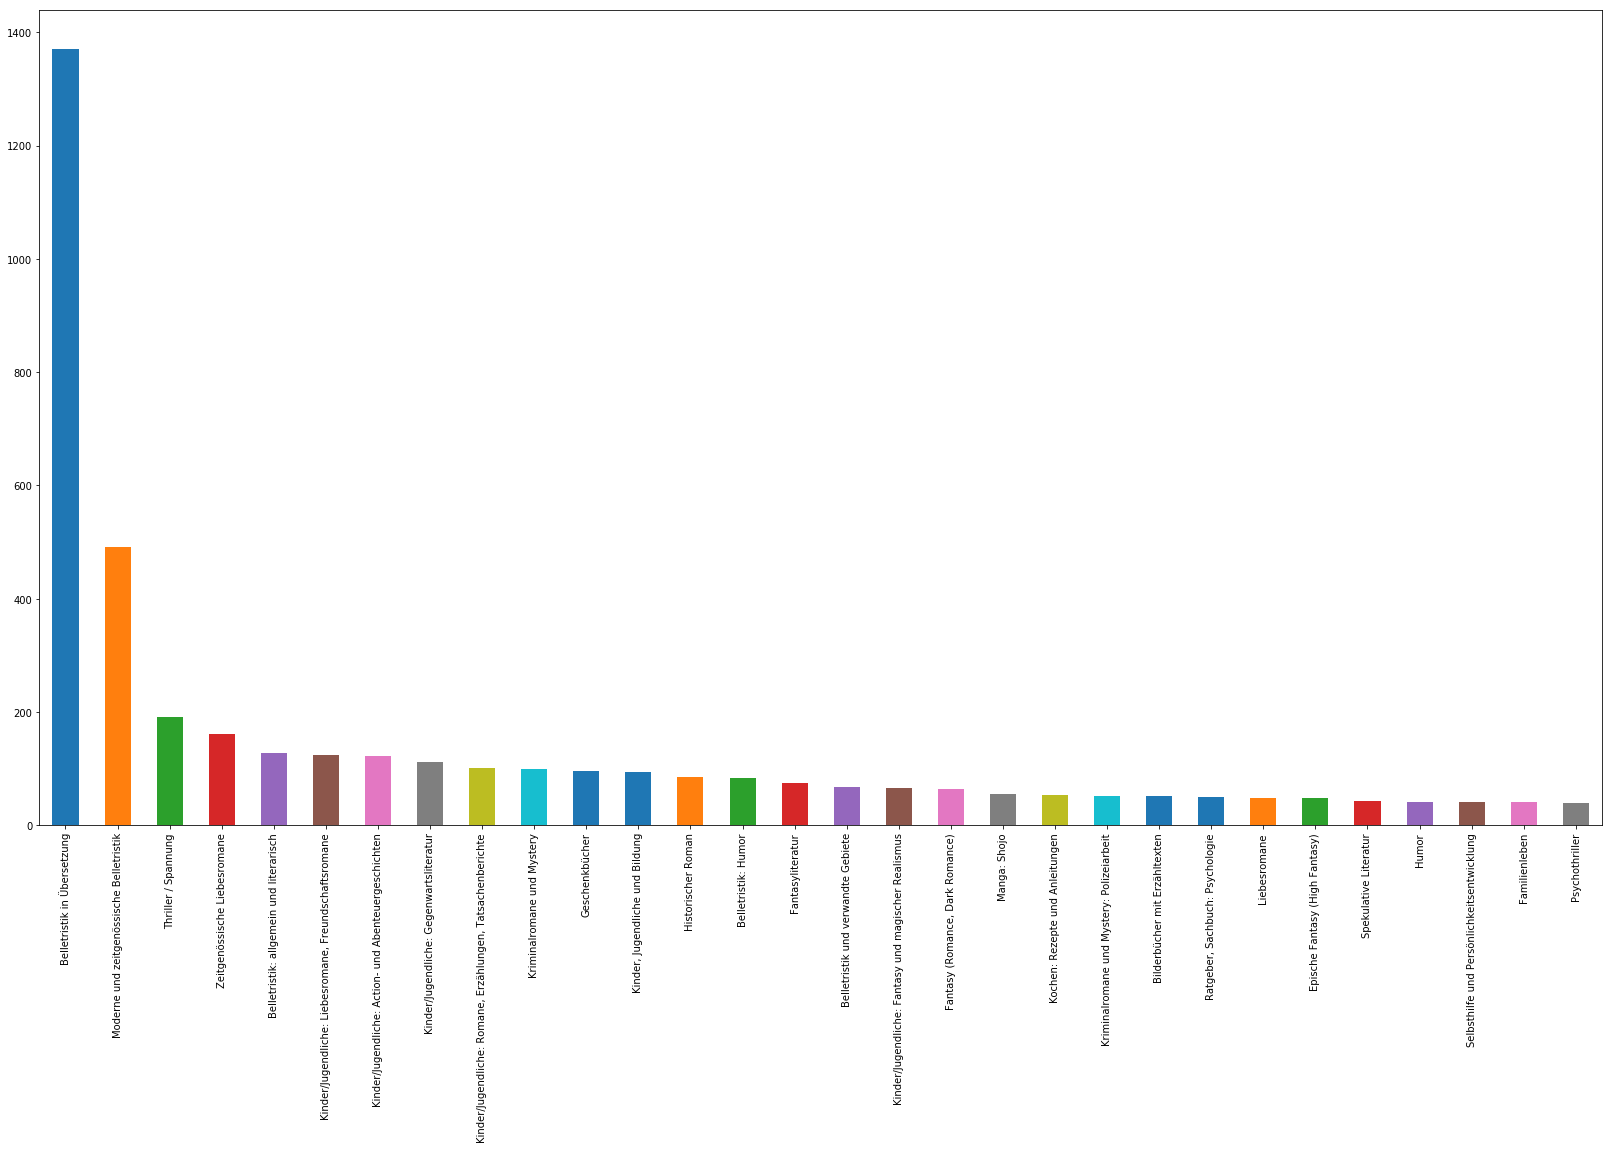

In [7]:
# taking data input and processing, reading first nrows ONLY
%time train = pd.read_csv("/home/D072852/Thalia_data/thalia.csv", sep='|', nrows=1000000)
train = dataPreprocess(train)
# trying some plotting of data wrt THEMES for first million records
data_explore(train, "THEME", 40)
print "----------------------------------------------------------------"

In [12]:
# fist look at the data with all columns and NO duplicate entries in terms of "Additional Text"
train.head(10)

,MATNR,ARTIDENTNO,ADDITIONALTEXT,RATING,RATINGTITEL,RATINGTEXT,RATEDAT,SCHLAGWORT,CATEGORY,THEME
0,A1026834633,33669870,PECUNIA<br>Der Versicherungs-Ratgeber von Dirk...,50,sehr gutes buch,Dieses Werk hat mir sehr geholfen bei meiner E...,08.12.12 15:57,Kartonierter Einband (Kt),mainsubject,Selbsthilfe und Persönlichkeitsentwicklung
20,A1022787682,32054271,Hündchen Bello möchte krähen können wie Hahn K...,50,Kindheitserinnerungen...,Was habe ich die Geschichten ums Entlein Schna...,06.07.12 11:42,Audio CD (CD/SACD) (CD),mainsubject,"Kinder/Jugendliche: Romane, Erzählungen, Tatsa..."
27,A1030481443,35358198,<p>Hana verliebt sich in einen mysteriösen jun...,50,Wolf oder Mensch?,Ame & Yuki  Die Wolfskinder ist eine wunder...,16.12.14 13:01,Kartonierter Einband (Kt),mainsubject,Manga: Shojo
35,A1029053070,34461069,"Vampir, Werwolf und Dämonin &amp;#8211; mit di...",40,Zufriedenstellendes Ende der Trilogie,Nach den Ereignissen in Göttin der Finsternis...,25.11.16 15:09,Kartonierter Einband (Kt),subject,"Fantasy (Romance, Dark Romance)"
71,A1038964023,44807019,"Was tun, wenn ein Baum plötzlich Bonbonfrüchte...",50,Wenn Du auf einen Bonbonbaum triffst...,Kurzbeschreibung\nWas würde passieren wenn ihr...,22.05.16 09:00,Fester Einband,subject,Kinder/Jugendliche: Lustige Romane
91,A1020288803,30809711,<p>Brauchen Sie eine kleine Erfrischung? Haben...,50,Eiscreme,Leckeres Eis und Milchshakes selber machen kli...,06.05.13 18:38,Fester Einband,subject,Kochen: Desserts
316,A1037783195,43862745,<p>Eine Methodengeschichte psychologischer For...,50,Methodengeschichte psychologischer Forschung u...,"Von Sternen, Fröschen und Monaden  wie man de...",08.09.17 13:48,Kartonierter Einband (Kt),mainsubject,"Ratgeber, Sachbuch: Psychologie"
332,A1014446928,24574132,Winter 1947 in Hohenschöpping im Havelland. Dr...,50,Jora und Knopotschka,Hohenschöpping im Havelland im Winter 1947. Ei...,19.10.10 17:47,Fester Einband,mainsubject,Geschichte
344,A1010991253,19910830,Das Zimmer Rumpelkammer ist einer der Wohnräum...,50,"Bravo, ein im wahrsten Sinne lebendiges Kinder...",Ich habe lange nach dem richtigen Buch für mei...,27.03.10 22:28,Kartonierter Einband (Kt),mainsubject,"Kinder/Jugendliche: Romane, Erzählungen, Tatsa..."
345,A1034729376,40940039,Mit seiner landschaftlichen Schönheit und sage...,50,Michael Lange - Fluss,"Michael Lange - Fluss\n\nDer Rhein, deutscher ...",16.06.15 13:49,Fester Einband,mainsubject,Fotografie


----------------------------------------------------------------
CHECKING for themes now
count                                 134
unique                                  3
top       Kochen: Rezepte und Anleitungen
freq                                   53
Name: THEME, dtype: object
DISTRIBUTION of THEMES:
Kochen: Rezepte und Anleitungen    53
Humor                              41
Psychothriller                     40
Name: THEME, dtype: int64
CHECKING for keywords now
count                           134
unique                           66
top       Kartonierter Einband (Kt)
freq                             20
Name: SCHLAGWORT, dtype: object
DISTRIBUTION of Schlagworts:
Kartonierter Einband (Kt)                          20
Fester Einband                                     15
Thriller                                           10
Roman                                               6
Audio CD (CD/SACD) (CD)                             6
Psychothriller                                     

,MATNR,ARTIDENTNO,ADDITIONALTEXT,RATING,RATINGTITEL,RATINGTEXT,RATEDAT,SCHLAGWORT,CATEGORY,THEME
891787,A1043362981,47092932,Der neue Spannungsroman von Paula Hawkins nach...,50,Beckford ist kein Ort für Selbstmörder. Beckf...,Und wieder ist der Thriller von Paula Hawkins ...,28.05.17 14:18,Kartonierter Einband (Kt),mainsubject,Psychothriller
892590,A1030317773,35146784,Traue niemandem &amp;#8211; nicht einmal dir s...,50,Wenn man sich selbst nicht trauen kann,Seit dem Tod ihres kleinen Bruders Kai wird Do...,04.06.14 12:44,Taschenbuch (kartoniert),subject,Psychothriller
894659,A1037739737,43822165,"Eat Clean, Feel Great! <br></br><br /></br>Unt...",30,Der Augenmerk ist zu sehr auf teure und exklus...,Meine Meinung zum Kochbuch: \nClean Eating Nat...,21.08.16 09:48,Gesunde Ernährung,subject,Kochen: Rezepte und Anleitungen
895262,A1045125439,62295012,Ihr Name war Zena. Tom macht kein Geheimnis au...,30,Mir fehlt das gewisse Etwas eines Thrillers,Eigentlich könnte Carmen kaum glücklicher sein...,01.10.17 19:48,Psychothriller,mainsubject,Psychothriller
896902,A1042992549,47877784,Die kleine Tochter der alleinerziehenden Lehre...,50,Lässt tief in menschliche Abgründe blicken,Geständnisse erzählt die Geschichte vom Mord...,16.06.17 07:47,Roman,mainsubject,Psychothriller


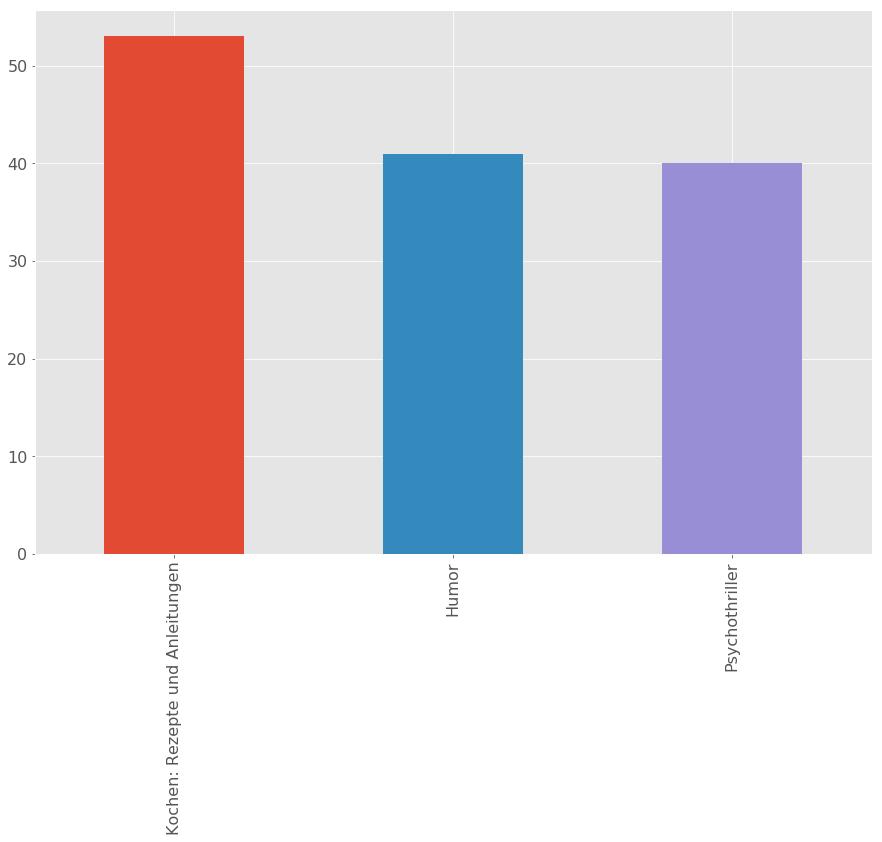

In [13]:
# Now pruning the data to keep only top 10 THEMES for further clustering evaluation
# train = data_prune(train, 'THEME', 120)
print "----------------------------------------------------------------"
# keeping only values relating to specific "un-related" THEMES
train = train.loc[train['THEME'].isin(['Kochen: Rezepte und Anleitungen','Humor','Psychothriller'])]
# trying some plotting of data wrt THEMES
dataVisualise(train)

train_text = train['ADDITIONALTEXT'].tolist()
train_id = train['MATNR'].tolist()
train_theme = train['THEME'].tolist()
train_schalgwort = train['SCHLAGWORT'].tolist()

print len(train_id)
print type(train_id)
print len(train_text)
print type(train_text)

total_len = 0
# calculating the average text lenght in training corpus
for s in train_text:
    total_len = total_len + len(s.split())
average_text_len = total_len/len(train_text)

print "Average length of the documents in training corpus is", average_text_len

train.head()
train.tail()

In [37]:
# Actual data preprocessing starts from here - 

# load nltk's SnowballStemmer as variabled 'stemmer'
# NOTE - this stemmer works by brute force chunking of fthe "en"/"es" from word endings plus it removes 1. casing information 2. Umlaut and special character information. On the whole lot of information loss. Advice to use SPACY lemmatizer.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

# Lemmatizer does NOT work for Deutsche language 
# from nltk.stem import WordNetLemmatizer
# wnl = WordNetLemmatizer()

# generating list of stop_words with title case to be removed from text as well
stop_words = stopwords.words('german')
stop_words_caps = [word.title() for word in stop_words]
stop_words.extend(stop_words_caps)
# extra missing (variations of) stop words that pop up in data
extra_stop_words = ["dass","amp", "Und", "her", "Her", "/br"]
stop_words.extend(extra_stop_words)
# print stop_words, len(stop_words)

# Here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) 
#     and words whose length is less than 2 characters - removes <br/a> formating from data 
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

print "BEFORE preprocess text looks like - "
print train_text[2]

#tokenize
%time tokenized_text = [tokenize_only(text.decode('utf-8')) for text in train_text]
%time tokenizedStemmed_text = [tokenize_and_stem(text.decode('utf-8')) for text in train_text]

print "done with tokenisation","After tokenisation text is -"
# print tokenized_text[0]
for word in tokenized_text[2]:
    print word,    
    
#remove stop words
%time texts = [[word for word in text if word not in stop_words] for text in tokenized_text]
print "done with stop word removal","After stop word removal text is -"
for word in texts[2]:
    print word,

BEFORE preprocess text looks like - 
<p>Riege 1928. Ein gemeiner Kinderstreich endet für Clara mit dem Tod. Vier Freundinnen schwören, niemals preiszugeben, was an jenem tragischen Tag im Wald bei den Ramselhöfen tatsächlich geschah.<br>Dreißig Jahre später stößt der englische Journalist Henry Miller auf das Geheimnis um Claras Tod udn kommt bei seinen Recherchen der Wahrheit gefährlich nahe. <br>Claras Todestag naht und unheimliche Dinge geschehen in Riege. Die vier Freundinnen bekommen es mit der Angst zu tun - und das zu Recht.</p>
CPU times: user 236 ms, sys: 16.2 ms, total: 252 ms
Wall time: 245 ms
CPU times: user 374 ms, sys: 32.5 ms, total: 407 ms
Wall time: 388 ms
done with tokenisation After tokenisation text is -
Riege Ein gemeiner Kinderstreich endet für Clara mit dem Tod Vier Freundinnen schwören niemals preiszugeben was jenem tragischen Tag Wald bei den Ramselhöfen tatsächlich geschah. Dreißig Jahre später stößt der englische Journalist Henry Miller auf das Geheimnis Clara

In [39]:
# Applying Word Movers Distance and analysing results on the current corpus
# http://proceedings.mlr.press/v37/kusnerb15.pdf

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(texts, model02, num_best=10)
start = time()

sims = instance[texts[80]]  # A query is simply a "look-up" in the similarity class.
print 'Cell took %.2f seconds to run.' %(time() - start)

Cell took 8.08 seconds to run.


In [40]:
# Print the query and the retrieved documents, together with their similarities.
print 'Query:'
# making a copy of the preprocessed data frame
work_df = train
print work_df.iloc()[80]['ADDITIONALTEXT']
# sanity check, indexes in the data frame and processed texts should point to same documents 
print " ".join(texts[80])
# print type(sims)
for i in range(10):
    print
    print 'sim = %.4f' % sims[i][1]
    print sims[i][0]
    print "Theme is %s" % work_df.iloc()[sims[i][0]]['THEME']
    print "Schlagworts are %s" % work_df.iloc()[sims[i][0]]['SCHLAGWORT']
    print work_df.iloc()[sims[i][0]]['ADDITIONALTEXT']
#     print (" ").join(texts[sims[i][0]])

Query:
Fesselnd, abgründig, raffiniert<br></br><br /></br>Er beobachtet das Leben wildfremder Frauen. Träumt sich an ihre Seite, in ihren Alltag. Identifiziert sich mit ihnen und will alles von ihnen wissen. Als Beobachter. Auf der Flucht vor seinem eigenen Dasein, das aus Misserfolgen besteht. Nur aus der Ferne liebt er die schöne Gillian Ward. Die beruflich erfolgreiche Frau, glücklich verheiratet, Mutter einer reizenden Tochter, wird von ihm über die Maßen idealisiert. Bis er zu seinem Entsetzen erkennt, dass er auf eine Fassade hereingefallen ist. Denn nichts ist so, wie es scheint. Gleichzeitig schreckt eine Mordserie die Menschen in London auf. Die Opfer: alleinstehende Frauen. Auf eine rachsüchtige, sadistische Weise umgebracht. Die Polizei sucht einen Psychopathen. Einen Mann, der Frauen hasst.<br></br><br /></br><br>
Fesselnd abgründig raffiniert beobachtet Leben wildfremder Frauen Träumt Seite Alltag Identifiziert wissen Beobachter Flucht eigenen Dasein Misserfolgen besteht F

In [41]:
# computing pairwise distance matrix for the given corpus using WMD
distance_WMD = np.zeros((len(texts),len(texts)))
%timeit
# distance_WMD = np.zeros((1000,1000))
print len(texts)
print distance_WMD.shape
# calculate distances only between different documents(i!=j) and 
# where the distance is not set yet(zero intialised)
# once calculated dist(i, j), set dist(j, i) to be the same value to save extra computations  
start = time()
for i in range(len(texts)):
    for j in range(len(texts)):
        if distance_WMD[i,j] == 0 and i != j:
            distance_WMD[i,j] = model.wmdistance(texts[i], texts[j])
            distance_WMD[j,i] = distance_WMD[i,j]
print 'Cell took %.2f seconds to run.' %(time() - start)

134
(134, 134)
Cell took 335.39 seconds to run.


In [42]:
from sklearn.externals import joblib
# saving/loading the model data
#since I've already run my model I am loading from the pickle
joblib.dump(distance_WMD,  'doc134_distance_WMD_model_.pkl')
# distance_WMD = joblib.load('doc134_distance_WMD_model01.pkl')

['doc134_distance_WMD_model_.pkl']

In [47]:
# using spectral clustering to cluster points represented by wmd_distamcep[n*n] matrix
# ToDo - check other available clustering algorithms performace for custom distance matrix
from sklearn.cluster import SpectralClustering
from sklearn import metrics
# Cluster
sc = SpectralClustering(3, affinity='precomputed', n_init=100)
sc.fit(distance_WMD)
# sc.fit(dist)
clusters_wmd = sc.labels_.tolist()

# Observation: Spectral clustering performs poorly on our data points and put them all 
# in one large cluster.

#create data frame that has the result of the cluster numbers and titles
df = pd.DataFrame(dict(cluster_label=clusters_wmd, theme=train_theme)) 
d=df.groupby(['cluster_label', 'theme']).theme.count()
d = d.groupby(level=0).apply(lambda x: x.sort_values(ascending=False))
print "distribution of documents across Theme are %s " % Counter(train_theme[:500])
print "distribution of documents across clusters are %s " % Counter(clusters_wmd)

# Number of documents belonging to a cluster grouped by the Theme 
d.head(100)

distribution of documents across Theme are Counter({'Kochen: Rezepte und Anleitungen': 53, 'Humor': 41, 'Psychothriller': 40}) 
distribution of documents across clusters are Counter({0: 132, 1: 1, 2: 1}) 


cluster_label  cluster_label  theme                          
0              0              Kochen: Rezepte und Anleitungen    51
                              Humor                              41
                              Psychothriller                     40
1              1              Kochen: Rezepte und Anleitungen     1
2              2              Kochen: Rezepte und Anleitungen     1
Name: theme, dtype: int64

In [50]:
# Using Manifold learning - Multidimensional Scaling technique to project higher dimension non linearly
# related data points from our distance_WMD matrix to lower dimension(2D) points as we're 
# plotting points in a two-dimensional plane.
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
from sklearn.manifold import MDS
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
# %time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
%time pos = mds.fit_transform(distance_WMD)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

CPU times: user 574 ms, sys: 15.6 ms, total: 590 ms
Wall time: 589 ms


In [51]:
# Evaluating the performance on PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
%time pos_pca = pca.fit_transform(distance_WMD)
xs_pca, ys_pca = pos_pca[:, 0], pos_pca[:, 1]

# Evaluating the performance on LLE
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=40, n_components=2, method='modified',
                               eigen_solver='auto')
%time pos_lle = model.fit_transform(distance_WMD)
xs_lle, ys_lle = pos_lle[:, 0], pos_lle[:, 1]

# Evaluating the performance on ISOMAP
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=10, n_components=2)
iso.fit(distance_WMD)
%time pos_isomap = iso.transform(distance_WMD)
xs_iso, ys_iso = pos_isomap[:, 0], pos_isomap[:, 1]
manifold_2Da = iso.transform(distance_WMD)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['x', 'y'])

# Left with 2 dimensions
manifold_2D.head()

# Evaluating performance on Tsne
%time pos_tsne = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(distance_WMD)
xs_tsne, ys_tsne = pos_tsne[:, 0], pos_tsne[:, 1]

CPU times: user 136 ms, sys: 309 ms, total: 444 ms
Wall time: 22.5 ms
CPU times: user 495 ms, sys: 796 ms, total: 1.29 s
Wall time: 137 ms
CPU times: user 24.6 ms, sys: 147 ms, total: 172 ms
Wall time: 7.2 ms
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.000s...
[t-SNE] Computed neighbors for 134 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 1.453894
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 52.5216866, gradient norm = 0.5893140 (50 iterations in 0.123s)
[t-SNE] Iteration 100: error = 52.4890251, gradient norm = 0.5561504 (50 iterations in 0.118s)
[t-SNE] Iteration 150: error = 53.6584587, gradient norm = 0.5190081 (50 iterations in 0.116s)
[t-SNE] Iteration 200: error = 53.2026100, gradient norm = 0.5561657 (50 iterations in 0.113s)
[t-SNE] Iteration 250: error = 56.1700783, gradient norm = 0.5243568 (50 iterations in 0.118s)
[t-SNE] KL divergence after 250

name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


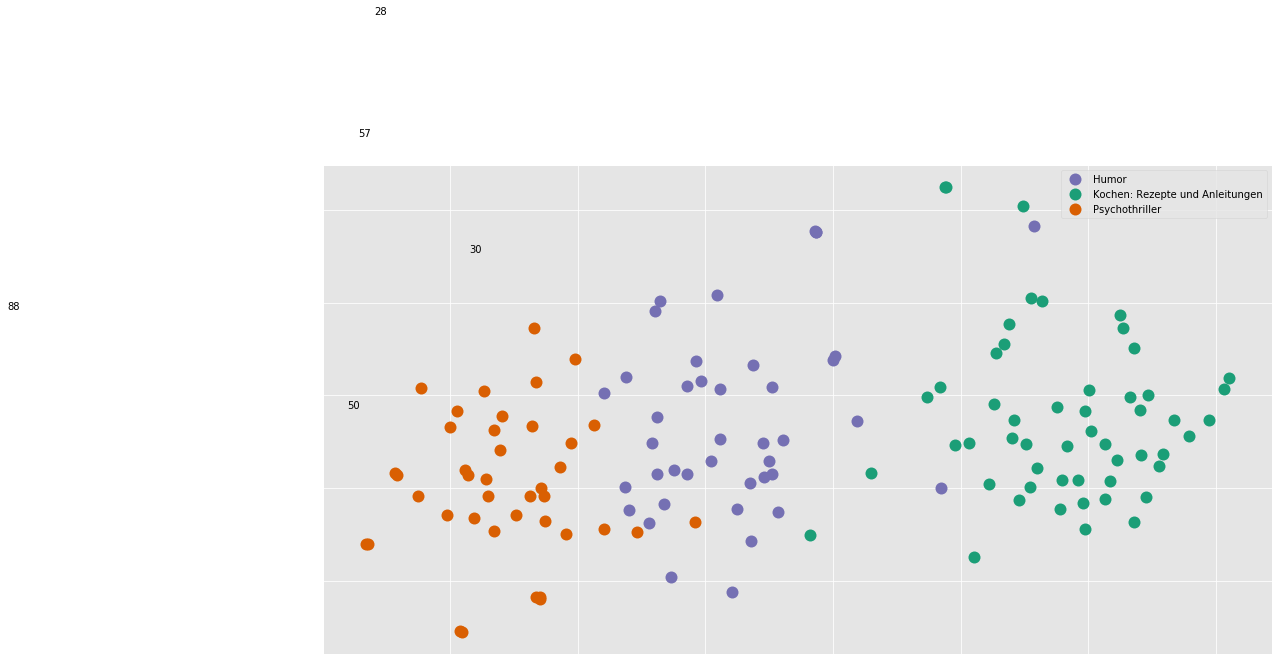

In [70]:
# setting up plot by "clustering" x's and y's based on WMD and reduced to 2D data points
#--------------------------------------------------------------------------------------

#set up colors per clusters using a dict
# #800000, #FFFF00, #8B0000, #9932CC, #ADFF2F
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#800000', 6: '#FFFF00', 7: '#8B0000', 8: '#9932CC', 9: '#ADFF2F', 10: '#228B22', 11: '#00FFFF'}

#set up cluster names using a dict
cluster_names = {0: 'Kochen: Rezepte und Anleitungen', 
                 1: 'Psychothriller', 
                 2: 'Humor', 
                 3: 'Bilderbücher mit Erzähltexten', 
                 4: 'Belletristik: allgemein und literarisch',
                 5: 'Selbsthilfe und Persönlichkeitsentwicklung', 
                 6: 'Kinder/Jugendliche: Action- und Abenteuergeschichten', 
                 7: 'Kinder/Jugendliche: Gegenwartsliteratur', 
                 8: 'Kinder/Jugendliche: Romane, Erzählungen, Tatsachenberichte', 
                 9: 'Kriminalromane und Mystery',
                 10: 'Geschenkbücher',
                 11: 'Kinder, Jugendliche und Bildung'}

inv_cluster_names = {v: k for k, v in cluster_names.iteritems()}

#set up cluster names according to cluster label using a dict
cluster_numbers= {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4',
                 5: 'Cluster 5', 
                 6: 'Cluster 6', 
                 7: 'Cluster 7', 
                 8: 'Cluster 8', 
                 9: 'Cluster 9',
                 10: 'Cluster 10',
                 11: 'Cluster 11'}


#create data frame that has the result of the MDS plus the cluster numbers and titles
df_mds = pd.DataFrame(dict(x=xs, y=ys, cluster_label=clusters_wmd, theme=train_theme, ID=train_id))
df_tsne = pd.DataFrame(dict(x=xs_tsne, y=ys_tsne, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_pca = pd.DataFrame(dict(x=xs_pca, y=ys_pca, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_lle = pd.DataFrame(dict(x=xs_lle, y=ys_lle, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))
df_iso = pd.DataFrame(dict(x=xs_iso, y=ys_iso, cluster_label=clusters_wmd, theme=train_theme, ID=train_id ))

# groups = []
# for df in [df_mds, df_tsne, df_pca, df_lle, df_iso]:
#     groups.append(df.groupby('theme'))

groups = df_tsne.groupby('theme')
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label

for name, group in groups:
    print "name of theme = %s, code = %s, color_key = %s" % ((name).decode('utf-8'), inv_cluster_names[name], cluster_colors[inv_cluster_names[name]])
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=(name).decode('utf-8'), color=cluster_colors[inv_cluster_names[name]], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# add label in x,y position with the document ID as an identifier
for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['ID'], size=10)  
    if (i == 50) or (i == 57) or (i == 28) or (i == 30) or (i == 88):  
        ax.text(df.iloc[i]['x'], df.iloc[i]['y'], i, size=10)      
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)